In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
% matplotlib inline
plt.style.use('ggplot')

# データの読み込み
データはKaggleからダウンロードできます。

[New York City Taxi Fare Prediction](https://www.kaggle.com/c/new-york-city-taxi-fare-prediction/data)

In [2]:
df = pd.read_csv('train.csv')
df.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


# 内容を大まかに確認

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 8 columns):
key                  50000 non-null object
fare_amount          50000 non-null float64
pickup_datetime      50000 non-null object
pickup_longitude     50000 non-null float64
pickup_latitude      50000 non-null float64
dropoff_longitude    50000 non-null float64
dropoff_latitude     50000 non-null float64
passenger_count      50000 non-null int64
dtypes: float64(5), int64(1), object(2)
memory usage: 3.1+ MB


In [4]:
df.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,11.364171,-72.509756,39.933759,-72.504616,39.926251,1.667840
std,9.685557,10.393860,6.224857,10.407570,6.014737,1.289195
min,-5.000000,-75.423848,-74.006893,-84.654241,-74.006377,0.000000
25%,6.000000,-73.992062,40.734880,-73.991152,40.734371,1.000000
50%,8.500000,-73.981840,40.752678,-73.980082,40.753372,1.000000
75%,12.500000,-73.967148,40.767360,-73.963584,40.768167,2.000000
max,200.000000,40.783472,401.083332,40.851027,43.415190,6.000000


# 経緯度に関するデータのみを抽出

In [5]:
df_location = df.loc[:, ['fare_amount', 'pickup_longitude', 'pickup_latitude',
                         'dropoff_longitude', 'dropoff_latitude']]
df_location.head()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude
0,4.5,-73.844311,40.721319,-73.841610,40.712278
1,16.9,-74.016048,40.711303,-73.979268,40.782004
2,5.7,-73.982738,40.761270,-73.991242,40.750562
3,7.7,-73.987130,40.733143,-73.991567,40.758092
4,5.3,-73.968095,40.768008,-73.956655,40.783762


# 欠損値・外れ値の処理
このデータフレームの場合、欠損値はありませんでした。

外れ値は四分位範囲を基準に削除します。

In [6]:
df.isnull().sum()

key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dtype: int64

In [7]:
def outlier_iqr(df, columns=None):
    if columns == None:
        columns = df.columns

    for col in columns:
        q1 = df[col].describe()['25%']
        q3 = df[col].describe()['75%']
        #四分位範囲
        iqr = q3 - q1 
        
        outlier_min = q1 - iqr * 1.5
        outlier_max = q3 + iqr * 1.5

        df = df[(df[col] >= outlier_min) & (df[col] <= outlier_max)]
        
    return df

In [8]:
df_location = outlier_iqr(df_location, columns=['fare_amount'])
df_location.shape

(45635, 5)

# 球面三角法をつかった２地点間の距離の計算
球面三角法をつかって２地点間のおおよその距離を計算します。

詳しい計算方法については省略します。関数化したのでこのままお使いください。単位はkmです。

In [9]:
def calculation_distance(x_1, y_1, x_2, y_2):
    # 赤道半径 (km)
    R = 6371
    # Radian角に変換
    _x1, _y1, _x2, _y2  = map(np.radians, [x_1, y_1, x_2, y_2])
    
    delta_x = _x2 - _x1
    delta_y = _y2 - _y1
    
    # 距離を計算
    a = np.sin(delta_y/2.0)**2 + np.cos(_y1) * np.cos(_y2) * np.sin(delta_x/2.0)**2
    return 2 * R * np.arcsin(np.sqrt(a))

In [10]:
df_location['distance'] = calculation_distance(df_location['pickup_longitude'], 
                                               df_location['pickup_latitude'],  
                                               df_location['dropoff_longitude'], 
                                               df_location['dropoff_latitude'])
df_location.head()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,distance
0,4.5,-73.844311,40.721319,-73.841610,40.712278,1.030764
1,16.9,-74.016048,40.711303,-73.979268,40.782004,8.450134
2,5.7,-73.982738,40.761270,-73.991242,40.750562,1.389525
3,7.7,-73.987130,40.733143,-73.991567,40.758092,2.799270
4,5.3,-73.968095,40.768008,-73.956655,40.783762,1.999157


# 方角を計算
２地点の経緯度を使って出発点から見た到達点の方角を計算します。

方角は360°で表記し、0°が真北、180°が南を示します。

In [11]:
def calculation_azimuth(x_1, y_1, x_2, y_2):
    # Radian角に修正
    _x1, _y1, _x2, _y2 = map(np.radians, [x_1, y_1, x_2, y_2])
    
    delta_x = _x2 - _x1
    _y = np.sin(delta_x)
    _x = np.cos(_y1) * np.tan(_y2) - np.sin(_y1) * np.cos(delta_x)

    psi = np.rad2deg(np.arctan2(_y, _x))
    
    return np.where(psi < 0, 360 + psi, psi)

In [12]:
df_location['azimuth'] = calculation_azimuth(df_location['pickup_longitude'], 
                                             df_location['pickup_latitude'], 
                                             df_location['dropoff_longitude'], 
                                             df_location['dropoff_latitude'])
df_location.head()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,distance,azimuth
0,4.5,-73.844311,40.721319,-73.841610,40.712278,1.030764,167.240469
1,16.9,-74.016048,40.711303,-73.979268,40.782004,8.450134,21.498365
2,5.7,-73.982738,40.761270,-73.991242,40.750562,1.389525,211.033211
3,7.7,-73.987130,40.733143,-73.991567,40.758092,2.799270,352.327836
4,5.3,-73.968095,40.768008,-73.956655,40.783762,1.999157,28.802783


# 方位にカテゴライズ
先ほどの関数を使って求めた360°表記の角度をカテゴリ変数に変換します。

ラベルエンコーダーを適用することを考えて、方角を数字に変換して出力します。

n_ways=8（つまり8方位）のときは、0が北、1が北東、…、7が北西です。

In [13]:
# 方位にカテゴライズ
def direction(azimuth, n_ways=8):
    bins = np.linspace(0, 360, n_ways+1) 
    # 方位角に22.5°を足す。
    _azimuth = azimuth + 180/n_ways
    _azimuth = np.where(_azimuth >= 360, _azimuth - 360, _azimuth)
    return np.digitize(_azimuth, bins=bins) - 1

df_location['direction'] = direction(df_location['azimuth'])
df_location.head(10)

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,distance,azimuth,direction
0,4.5,-73.844311,40.721319,-73.841610,40.712278,1.030764,167.240469,4
1,16.9,-74.016048,40.711303,-73.979268,40.782004,8.450134,21.498365,0
2,5.7,-73.982738,40.761270,-73.991242,40.750562,1.389525,211.033211,5
3,7.7,-73.987130,40.733143,-73.991567,40.758092,2.799270,352.327836,0
4,5.3,-73.968095,40.768008,-73.956655,40.783762,1.999157,28.802783,1
5,12.1,-74.000964,40.731630,-73.972892,40.758233,3.787239,38.631713,1
6,7.5,-73.980002,40.751662,-73.973802,40.764842,1.555807,19.610063,0
7,16.5,-73.951300,40.774138,-73.990095,40.751048,4.155444,231.852498,5
8,9.0,-74.006462,40.726713,-73.993078,40.731628,1.253232,64.140893,1
9,8.9,-73.980658,40.733873,-73.991540,40.758138,2.849627,341.237758,0


In [14]:
df_location['direction'].value_counts()

1    9846
5    8802
0    8342
4    6903
3    3227
2    3120
7    2765
6    2630
Name: direction, dtype: int64

# 位置情報を可視化
plt.scatterメソッドを使って、位置情報を可視化します。

引数については、xに経度、yに緯度、axisに表示範囲をタプル型の経緯度を指定します。

In [15]:
def plot_location(x, y, axis):
    plt.scatter(x, y, s=1.0, alpha=0.5)
    plt.axis(axis)

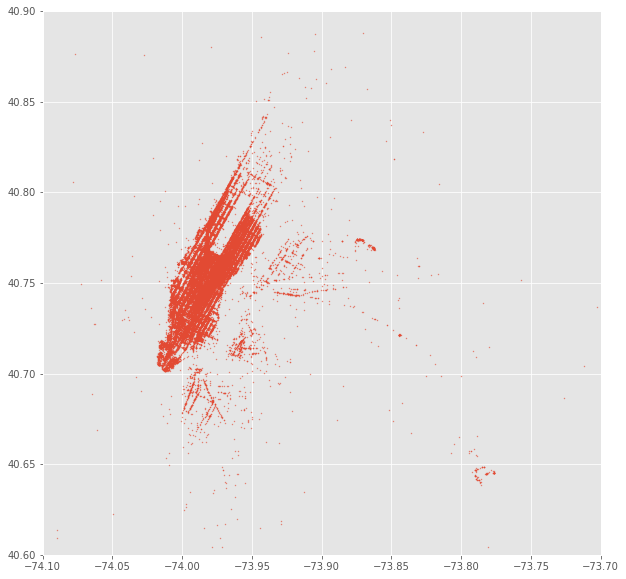

In [16]:
plt.figure(figsize=(10, 10))
plot_location(df_location['pickup_longitude'], df_location['pickup_latitude'], 
              axis=[-74.1, -73.7, 40.6, 40.9])

# データに合わせて点の色と大きさを変更
プロットする点の大きさと色を別のデータを参照して変更します。



In [17]:
def plot_with_color(x, y, data, axis=None):
    plt.scatter(x, y, s=data, c=data, cmap=plt.get_cmap('jet'), alpha=0.3)
    plt.axis(axis)
    plt.colorbar()

    plt.xlabel('longitude', fontsize=15)
    plt.ylabel('latitude', fontsize=15)

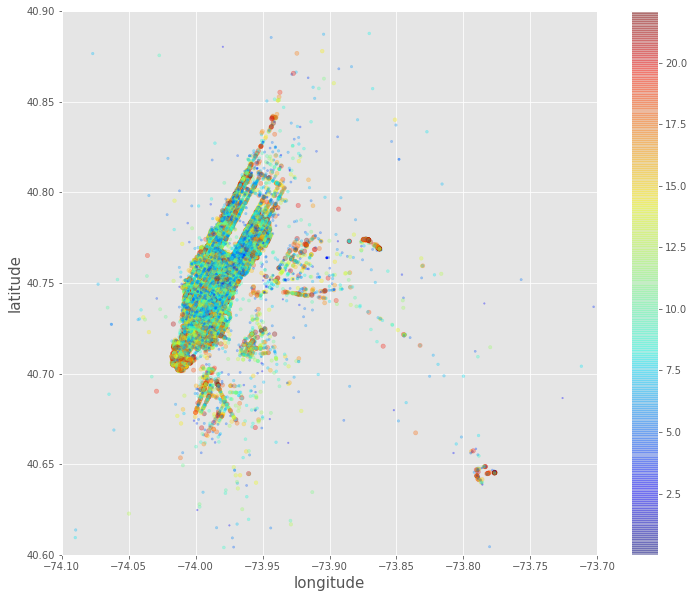

In [18]:
df_location = df_location[(df_location['fare_amount'] > 0) & (df_location['fare_amount'] <= 30)]

plt.figure(figsize=(12, 10))
plot_with_color(x=df_location['pickup_longitude'], 
                y=df_location['pickup_latitude'],
                data=df_location['fare_amount'],
                axis=[-74.1, -73.7, 40.6, 40.9])

# df.plot(kind='scatter', x='pickup_longitude', y='pickup_latitude', alpha=0.3,
#         s=df['fare_amount'],figsize=(10, 8), xlim=(-74.1, -73.7), ylim=(40.6, 40.9),
#         c='fare_amount', cmap=plt.get_cmap('jet'))